In [ ]:
!pip install evaluate

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from tqdm import tqdm
import evaluate
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

BASE_DIR = r"C:\Users\arvap\OneDrive\Documents\Desktop\revitt\data"
IMG_DIR = os.path.join(BASE_DIR, "images")
MASK_DIR = os.path.join(BASE_DIR, "labelIds", "CropOrWeed2")
MODEL_CHECKPOINT = "nvidia/segformer-b2-finetuned-ade-512-512"

if not os.path.exists(IMG_DIR) or not os.path.exists(MASK_DIR):
    print("WARNING!!!: Directories not found")

Using device: cuda


In [ ]:
# 1. ExG Attention
class ExG_Attention(nn.Module):
    def __init__(self):
        super().__init__()
        # No learnable parameters needed for the pure math formula yet.

    def forward(self, images):
        # Input images shape: (Batch_Size, 3, Height, Width)
        # We assume pixel values are normalized roughly to [0, 1] or [0, 255]

        # 1. Split the channels (Red, Green, Blue)
        r = images[:, 0, :, :]
        g = images[:, 1, :, :]
        b = images[:, 2, :, :]

        # 2. Calculate Excess Green Index
        # Formula: ExG = 2*G - R - B
        exg_raw = (2 * g) - r - b

        # 3. Create the Attention Mask (Squash to 0-1 range)
        # We use Sigmoid because we want a probability-like mask.
        attention_mask = torch.sigmoid(exg_raw)

        # 4. Restore Channel Dimension
        # The math reduced shape to (Batch, H, W).
        # We need (Batch, 1, H, W) to multiply with other features later.
        attention_mask = attention_mask.unsqueeze(1)

        return attention_mask

In [ ]:
# 2. Parallel Detail Decoder
class ParallelDetailDecoder(nn.Module):
    """
    Architecture:
    1. Projects all Encoder stages (1-4) to a common embedding dimension.
    2. Upsamples them all to the size of Stage 1.
    3. Concatenates them into one massive tensor (The "Bucket").
    4. Fuses them using a single Conv2D layer (Enables RDD Pruning).
    5. Adds the Stage 1 features back to the result (Residual Connection) to force edge details.
    """
    def __init__(self, encoder_channels, num_classes, embedding_dim=256):
        super().__init__()

        # 1. Lateral Layers (1x1 Convolutions)
        # Projects [64, 128, 320, 512] -> [256, 256, 256, 256]
        self.lateral_convs = nn.ModuleList()
        for channels in encoder_channels:
            self.lateral_convs.append(
                nn.Conv2d(channels, embedding_dim, kernel_size=1)
            )

        # 2. The Big Fusion Layer (Equivalent to Conv2DFuse)
        # Input: embedding_dim * 4 (because we concat 4 stages)
        # Output: embedding_dim
        # This is the layer we will "slice" later for RDD.
        self.linear_fuse = nn.Sequential(
            nn.Conv2d(in_channels=embedding_dim * 4, out_channels=embedding_dim, kernel_size=1, bias=False),
            nn.BatchNorm2d(embedding_dim),
            nn.ReLU()
        )

        # 3. Final Prediction Head
        self.prediction_head = nn.Conv2d(embedding_dim, num_classes, kernel_size=1)

    def forward(self, features):
        # features = [c1, c2, c3, c4]

        # A. Project all stages
        projected = [layer(f) for layer, f in zip(self.lateral_convs, features)]

        # B. Upsample everything to match Stage 1 (High Res)
        # c1 is usually 1/4th of image size
        target_size = projected[0].shape[-2:]
        upsampled_features = []
        for p in projected:
            upsampled_features.append(
                F.interpolate(p, size=target_size, mode='bilinear', align_corners=False)
            )

        # C. FUSE ALL (The "Bucket")
        # Concatenate along channel dimension
        concatenated = torch.cat(upsampled_features, dim=1)

        # D. Apply Fusion
        fused = self.linear_fuse(concatenated)

        # E. RESIDUAL DETAIL INJECTION
        # We explicitly ADD Stage 1 features back to the fused result.
        # This ensures high-frequency details (edges) are not lost in the fusion.
        fused = fused + projected[0]

        # F. Predict
        logits = self.prediction_head(fused)

        return logits

In [ ]:
# --- 3. Research Grade Wrapper (Updated) ---
"""
 1. Input: Image (512 × 512)
 2. Branch A (Bio): Calculate ExG Mask (512 x 512).
 3. Branch B (DL): Encoder produces features (S1, S2, S3, S4).
 4. Interaction: S4 is multiplied by the ExG Mask. "Soil" features are deleted.
 5. Decoder: Fuses (S1, S2, S3, S4_refined) + Adds S1 edge details.
 6. Output: Segmentation Map.
"""
class SegFormer_Research_Grade(nn.Module):
    def __init__(self, pretrained_model_name, num_classes):
        super().__init__()

        # A. Loading Backbone
        self.base_model = SegformerForSemanticSegmentation.from_pretrained(
            pretrained_model_name,
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )

        # B. Config(we need to know how many channels encoder outputs at each stage) i.e [64,128,320, 512]
        encoder_channels = self.base_model.config.hidden_sizes

        # C. Biological Prior -> Our little Excess Green index module
        self.exg_module = ExG_Attention()

        # D.Parallel Decoder
        self.custom_decoder = ParallelDetailDecoder(
            encoder_channels=encoder_channels,
            num_classes=num_classes
        )

    def forward(self, pixel_values, labels=None):
        # 1. ExG Attention
        exg_mask = self.exg_module(pixel_values)

        # 2. Encoder Forward Pass
        outputs = self.base_model.segformer(
            pixel_values,
            output_hidden_states=True
        )
        all_hidden_states = outputs.hidden_states

        # 3. Feature Gating (ExG Intervention on Deepest Feature)
        last_feature_map = all_hidden_states[-1]
        mask_resized = F.interpolate(exg_mask, size=last_feature_map.shape[-2:], mode='nearest')
        refined_last_feature = last_feature_map * mask_resized

        # Update feature list
        features_for_decoder = list(all_hidden_states)
        features_for_decoder[-1] = refined_last_feature

        # Note: SegFormer returns [Input_Embed, S1, S2, S3, S4]
        # We usually want just the stages [S1, S2, S3, S4]
        # The 'all_hidden_states' usually includes the initial embeddings at index 0.
        # However, HuggingFace implementation varies slightly by version.
        # Ideally, we pass the last 4 elements.
        encoder_features = features_for_decoder[-4:]

        # 4. Custom Parallel Decoding
        logits = self.custom_decoder(encoder_features)

        # 5. Final Resize (to original image size)
        upsampled_logits = F.interpolate(
            logits,
            size=pixel_values.shape[-2:],
            mode='bilinear',
            align_corners=False
        )

        # 6. Loss
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=255)
            loss = loss_fct(upsampled_logits, labels)

        return (loss, upsampled_logits) if loss is not None else upsampled_logits

In [ ]:
class CropWeedDataset(Dataset):
    def __init__(self, img_dir, mask_dir, processor):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.processor = processor

        # 1. Identify all valid pairs
        mask_files = set(f for f in os.listdir(mask_dir) if f.endswith('.png'))
        img_files = set(f for f in os.listdir(img_dir) if f.endswith('.jpg'))

        # Find intersection
        self.valid_files = []
        for m_file in mask_files:
            i_file = m_file.replace(".png", ".jpg")
            if i_file in img_files:
                self.valid_files.append((i_file, m_file))

        self.valid_files.sort()
        print(f"Dataset Initialized. Found {len(self.valid_files)} valid image/mask pairs.")

    def __len__(self):
        return len(self.valid_files)

    def __getitem__(self, idx):
        img_name, mask_name = self.valid_files[idx]

        # Load File
        image = Image.open(os.path.join(self.img_dir, img_name)).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir, mask_name))

        # Process (Resize, Normalize, Convert to Tensor)
        encoding = self.processor(
            images=image,
            segmentation_maps=mask,
            return_tensors="pt"
        )

        pixel_values = encoding.pixel_values.squeeze()
        labels = encoding.labels.squeeze()

        return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
# 1. Define Processor
processor = SegformerImageProcessor.from_pretrained(MODEL_CHECKPOINT)

# 2. Instantiate Full Dataset
try:
    full_dataset = CropWeedDataset(IMG_DIR, MASK_DIR, processor)

    # 3. Split Train/Val (90% / 10%)
    train_size = int(0.9 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    print(f" > Training Samples:   {len(train_dataset)}")
    print(f" > Validation Samples: {len(val_dataset)}")

    # 4. Create Loaders
    train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

except FileNotFoundError:
    print("Skipping Dataset creation (files not found). Ensure paths are correct.")

Dataset Initialized. Found 7704 valid image/mask pairs.
 > Training Samples:   6933
 > Validation Samples: 771


C:\Users\arvap\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


In [ ]:
# --- 1. Define ID Mappings ---
id2label = {0: "Crop", 1: "Weed", 2: "Soil"}
label2id = {v: k for k, v in id2label.items()}

# --- 2. Load the Custom Research Grade Model ---
# INTEGRATION STEP: We use the custom class defined in Block 4
print("Initializing SegFormer Research Grade (ExG + Custom Decoder)...")
model = SegFormer_Research_Grade(
    pretrained_model_name=MODEL_CHECKPOINT,
    num_classes=3
)
model.to(device)

# --- 3. Optimizer ---
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
print("Model and Optimizer prepared.")

Initializing SegFormer Research Grade (ExG + Custom Decoder)...


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([3, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and Optimizer prepared.


In [ ]:
# --- Configuration ---
NUM_EPOCHS = 7
SAVE_DIR = "segformer_crop_weed_finetuned_v4.0"
os.makedirs(SAVE_DIR, exist_ok=True)

# Initialize Metric
metric = evaluate.load("mean_iou")
best_miou = 0.0

print(f"Starting Fine-Tuning for {NUM_EPOCHS} Epochs...")
print("-" * 60)

for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch + 1}/{NUM_EPOCHS}")

    # --- A. TRAINING PHASE ---
    model.train()
    train_loss = 0.0
    train_loader_tqdm = tqdm(train_dataloader, desc="Training")

    for batch in train_loader_tqdm:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # Forward Pass
        # Note: Our custom model returns a tuple (loss, logits)
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs[0] # Extract loss from tuple

        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_loader_tqdm.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(train_dataloader)
    print(f"  > Avg Training Loss: {avg_train_loss:.4f}")

    # --- B. VALIDATION PHASE ---
    model.eval()
    print("  > Validating...")

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Validation"):
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            # Inference (No labels passed, returns logits only usually, or (None, logits))
            # The custom model forward checks 'if labels is not None'.
            # If we don't pass labels, it returns 'upsampled_logits' directly.
            logits = model(pixel_values=pixel_values)

            # Upsample manually just in case, though model does it.
            # (Double checking shapes match exactly for metric)
            if logits.shape[-2:] != labels.shape[-2:]:
                 logits = F.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)

            # The model outputs probabilities for every class (e.g., [0.1, 0.8, 0.1]). Argmax picks the highest one (Index 1)
            predictions = logits.argmax(dim=1)
            # Instead of calculating the score immediately, we store the results in a "pile." We will calculate the average score at the very end.
            metric.add_batch(predictions=predictions, references=labels)

    # Compute mIoU
    metrics = metric.compute(num_labels=3, ignore_index=255, reduce_labels=False)
    current_miou = metrics["mean_iou"]
    mean_accuracy = metrics["mean_accuracy"]

    print(f"  > Validation mIoU:   {current_miou:.4f}")
    print(f"  > Mean Accuracy:     {mean_accuracy:.4f}")

    # --- C. SAVE BEST MODEL ---
    if current_miou > best_miou:
        print(f"  > [IMPROVEMENT] mIoU increased ({best_miou:.4f} -> {current_miou:.4f}). Saving model...")
        best_miou = current_miou
        # For custom models, we save state_dict or wrap in standard save logic.
        torch.save(model.state_dict(), os.path.join(SAVE_DIR, "custom_model_best.pth"))
        processor.save_pretrained(SAVE_DIR)
    else:
        print(f"  > mIoU did not improve (Best: {best_miou:.4f})")

print("Training Complete.")

Starting Fine-Tuning for 7 Epochs...
------------------------------------------------------------

EPOCH 1/7


Training: 100%|██████████████████████████████████████████████████████| 1734/1734 [11:01<00:00,  2.62it/s, loss=0.00242]


  > Avg Training Loss: 0.0599
  > Validating...


Validation:   0%|                                                                              | 0/193 [00:00<?, ?it/s]C:\Users\arvap\AppData\Local\Programs\Python\Python310\lib\site-packages\datasets\features\image.py:371: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
Validation: 100%|████████████████████████████████████████████████████████████████████| 193/193 [01:02<00:00,  3.11it/s]


  > Validation mIoU:   0.7799
  > Mean Accuracy:     0.8596
  > [IMPROVEMENT] mIoU increased (0.0000 -> 0.7799). Saving model...

EPOCH 2/7


Training: 100%|██████████████████████████████████████████████████████| 1734/1734 [10:32<00:00,  2.74it/s, loss=0.00933]


  > Avg Training Loss: 0.0246
  > Validating...


Validation: 100%|████████████████████████████████████████████████████████████████████| 193/193 [00:56<00:00,  3.40it/s]


  > Validation mIoU:   0.8237
  > Mean Accuracy:     0.9025
  > [IMPROVEMENT] mIoU increased (0.7799 -> 0.8237). Saving model...

EPOCH 3/7


Training: 100%|██████████████████████████████████████████████████████| 1734/1734 [10:29<00:00,  2.75it/s, loss=0.00318]


  > Avg Training Loss: 0.0210
  > Validating...


Validation: 100%|████████████████████████████████████████████████████████████████████| 193/193 [00:56<00:00,  3.41it/s]


  > Validation mIoU:   0.8054
  > Mean Accuracy:     0.8868
  > mIoU did not improve (Best: 0.8237)

EPOCH 4/7


Training: 100%|██████████████████████████████████████████████████████| 1734/1734 [10:28<00:00,  2.76it/s, loss=0.00225]


  > Avg Training Loss: 0.0178
  > Validating...


Validation: 100%|████████████████████████████████████████████████████████████████████| 193/193 [00:55<00:00,  3.47it/s]


  > Validation mIoU:   0.8527
  > Mean Accuracy:     0.9340
  > [IMPROVEMENT] mIoU increased (0.8237 -> 0.8527). Saving model...

EPOCH 5/7


Training: 100%|███████████████████████████████████████████████████████| 1734/1734 [10:35<00:00,  2.73it/s, loss=0.0129]


  > Avg Training Loss: 0.0165
  > Validating...


Validation: 100%|████████████████████████████████████████████████████████████████████| 193/193 [01:05<00:00,  2.96it/s]


  > Validation mIoU:   0.8481
  > Mean Accuracy:     0.9116
  > mIoU did not improve (Best: 0.8527)

EPOCH 6/7


Training: 100%|███████████████████████████████████████████████████████| 1734/1734 [11:05<00:00,  2.61it/s, loss=0.0118]


  > Avg Training Loss: 0.0165
  > Validating...


Validation: 100%|████████████████████████████████████████████████████████████████████| 193/193 [00:56<00:00,  3.43it/s]


  > Validation mIoU:   0.8557
  > Mean Accuracy:     0.9221
  > [IMPROVEMENT] mIoU increased (0.8527 -> 0.8557). Saving model...

EPOCH 7/7


Training: 100%|██████████████████████████████████████████████████████| 1734/1734 [10:33<00:00,  2.74it/s, loss=0.00241]


  > Avg Training Loss: 0.0152
  > Validating...


Validation: 100%|████████████████████████████████████████████████████████████████████| 193/193 [00:56<00:00,  3.39it/s]


  > Validation mIoU:   0.8707
  > Mean Accuracy:     0.9283
  > [IMPROVEMENT] mIoU increased (0.8557 -> 0.8707). Saving model...
Training Complete.


In [ ]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_predictions(model, source_dataloader, num_samples=3):
    model.eval()

    # Create a temporary loader with shuffle=True to pull random samples
    # We use the dataset from the source_dataloader
    temp_loader = DataLoader(
        source_dataloader.dataset,
        batch_size=num_samples,
        shuffle=True
    )

    # Get a random batch
    batch = next(iter(temp_loader))
    pixel_values = batch["pixel_values"].to(device)
    labels = batch["labels"].cpu().numpy()

    # Inference
    with torch.no_grad():
        # Custom model returns logits directly if no labels passed
        logits = model(pixel_values=pixel_values)

        # Safety check: If model returns tuple (loss, logits), take index 1
        if isinstance(logits, tuple):
            logits = logits[1]

    predictions = logits.argmax(dim=1).cpu().numpy()

    # Define Colors (Preserved exactly as requested)
    # 0=Crop(Blue), 1=Weed(Green), 2=Soil(Red/Brown)
    colors = np.array([
        [0, 0, 255],    # ID 0: Crop (Blue)
        [0, 255, 0],    # ID 1: Weed (Green)
        [139, 69, 19],  # ID 2: Soil (Brown)
    ]) / 255.0

    print(f"\nVisualizing {num_samples} RANDOM validation samples...")

    for i in range(num_samples):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # 1. Ground Truth Structure (Label only)
        axes[0].imshow(labels[i], cmap='gray')
        axes[0].set_title("Ground Truth Structure")
        axes[0].axis('off')

        # 2. Ground Truth Mask (Colored)
        # Use modulo 3 just in case ID 255 (ignore) sneaks in, mapping it to a valid color
        gt_rgb = colors[labels[i] % 3]
        axes[1].imshow(gt_rgb)
        axes[1].set_title("Ground Truth (Target)")
        axes[1].axis('off')

        # 3. Prediction (Colored)
        pred_rgb = colors[predictions[i]]
        axes[2].imshow(pred_rgb)
        axes[2].set_title("Research Grade Prediction")
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

Targeting weights at: C:\Users\arvap\OneDrive\Documents\Desktop\revitt\segformer_crop_weed_finetuned_v4.0\custom_model_best.pth


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([3, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SUCCESS: Model V2 loaded and ready.

Visualizing 3 RANDOM validation samples...


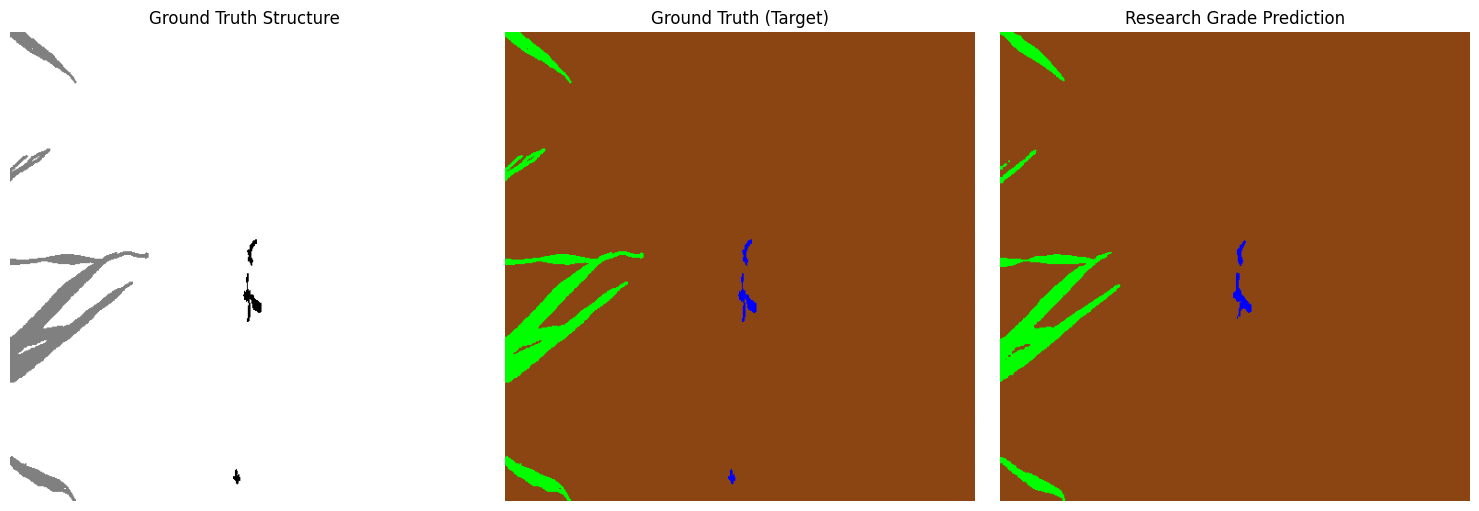

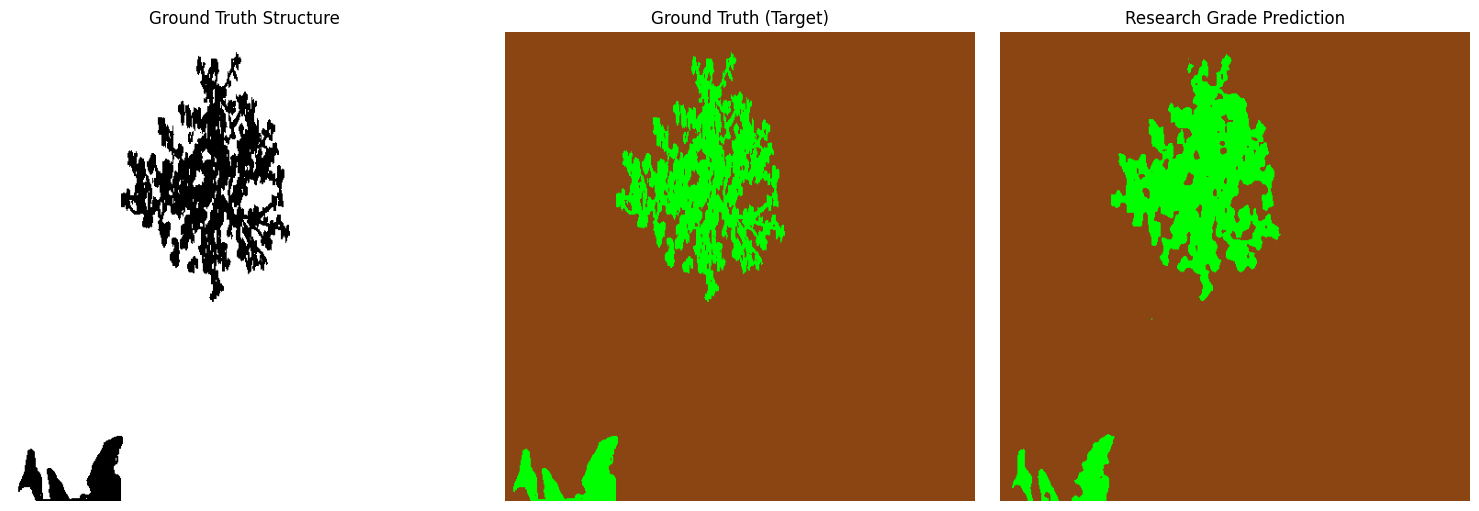

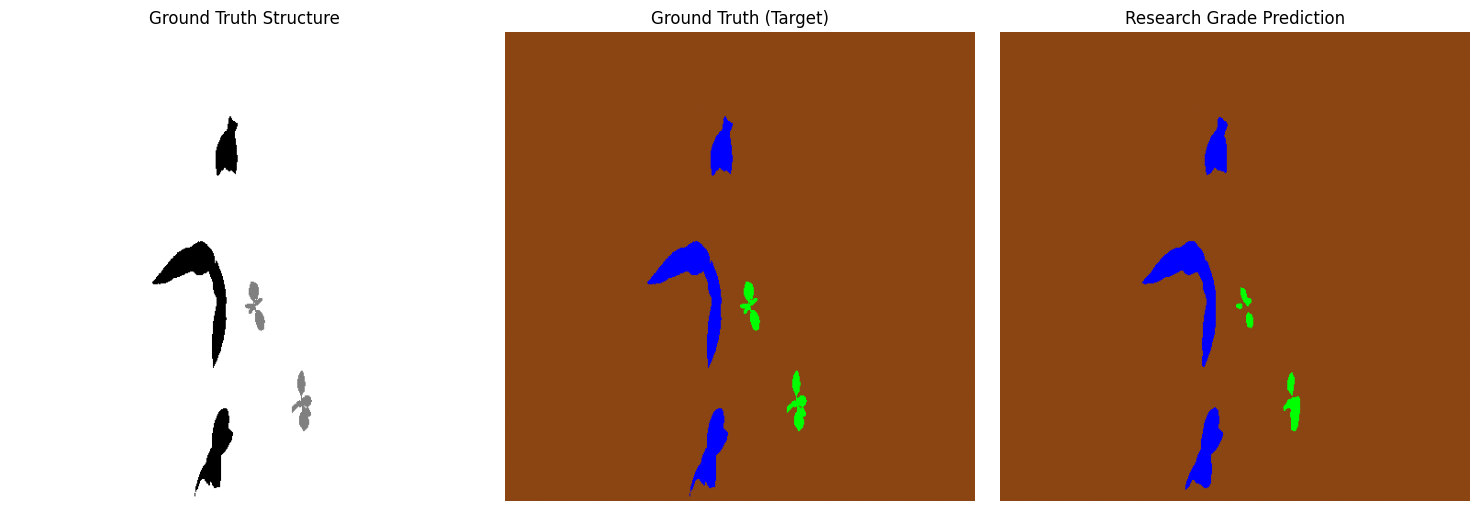

In [ ]:
import os
import torch

# --- 1. Define the Exact Path ---
# We point directly to the folder and file you confirmed exists
folder_name = r"C:\Users\arvap\OneDrive\Documents\Desktop\revitt\segformer_crop_weed_finetuned_v4.0"
filename = "custom_model_best.pth"
weights_path = os.path.join(folder_name, filename)

print(f"Targeting weights at: {weights_path}")

# --- 2. Initialize the Architecture ---
# We build the empty 'Research Grade' skeleton first
model_v2 = SegFormer_Research_Grade(
    pretrained_model_name="nvidia/segformer-b2-finetuned-ade-512-512",
    num_classes=3
)

# --- 3. Load the Weights ---
if os.path.exists(weights_path):
    # Load weights to CPU first to avoid memory errors, then move to GPU
    state_dict = torch.load(weights_path, map_location=device)
    model_v2.load_state_dict(state_dict)

    # Move to GPU
    model_v2.to(device)
    model_v2.eval()
    print("SUCCESS: Model V2 loaded and ready.")

    # --- 4. Run Visualization ---
    # This uses your previously defined visualize_predictions function
    if 'val_dataloader' in locals():
        visualize_predictions(model_v2, val_dataloader, num_samples=3)
    else:
        print("Error: val_dataloader is not defined. Please run the Dataset Setup block first.")

else:
    print(f"ERROR: File not found at {weights_path}")
    print("Double check that the folder name is exactly 'segformer_crop_weed_finetuned_v2'")

Targeting weights at: C:\Users\arvap\OneDrive\Documents\Desktop\revitt\segformer_crop_weed_finetuned_v4.0\custom_model_best.pth


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([3, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SUCCESS: Model V2 loaded and ready.

Visualizing 3 RANDOM validation samples...


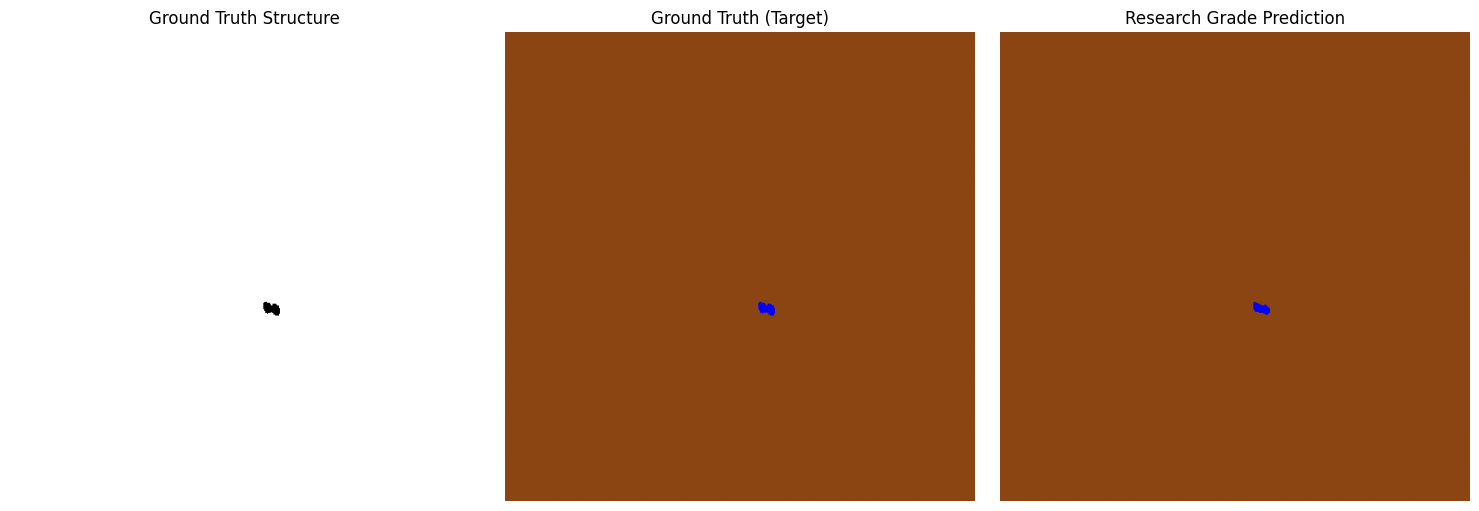

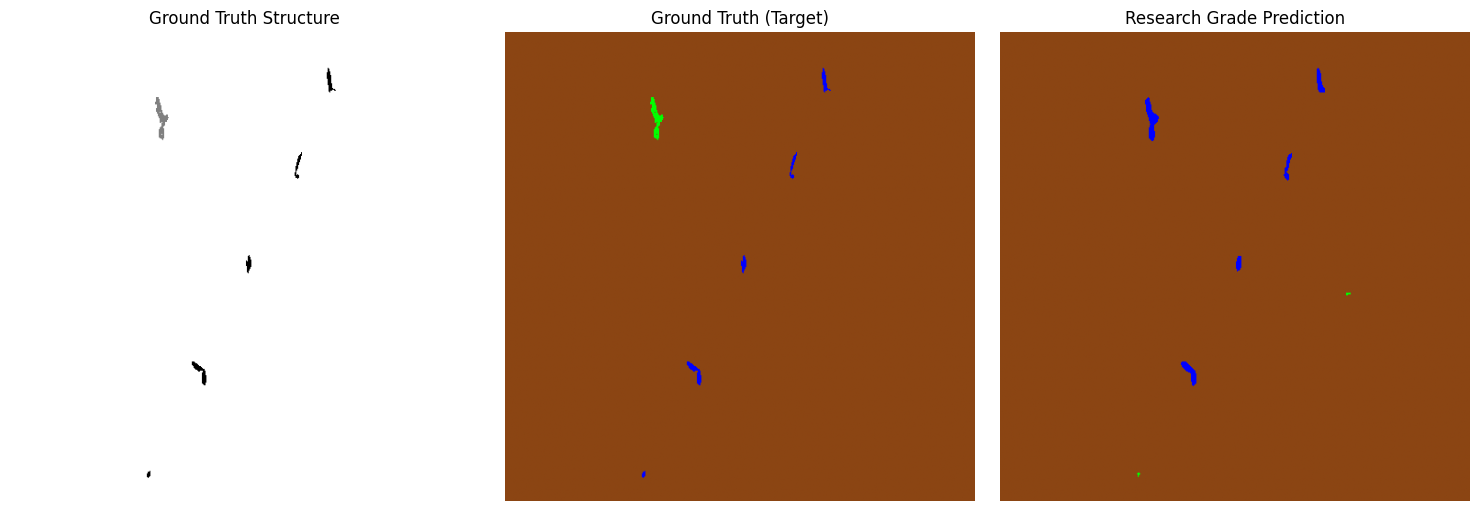

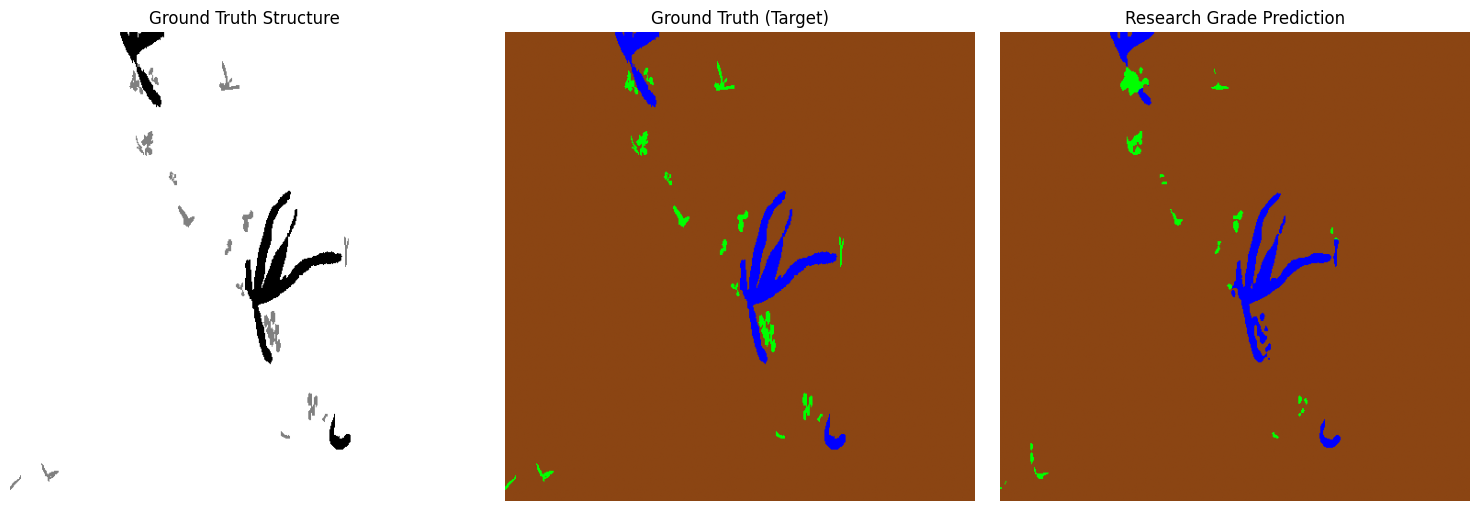

In [ ]:
import os
import torch

# --- 1. Define the Exact Path ---
# We point directly to the folder and file you confirmed exists
folder_name = r"C:\Users\arvap\OneDrive\Documents\Desktop\revitt\segformer_crop_weed_finetuned_v4.0"
filename = "custom_model_best.pth"
weights_path = os.path.join(folder_name, filename)

print(f"Targeting weights at: {weights_path}")

# --- 2. Initialize the Architecture ---
# We build the empty 'Research Grade' skeleton first
model_v2 = SegFormer_Research_Grade(
    pretrained_model_name="nvidia/segformer-b2-finetuned-ade-512-512",
    num_classes=3
)

# --- 3. Load the Weights ---
if os.path.exists(weights_path):
    # Load weights to CPU first to avoid memory errors, then move to GPU
    state_dict = torch.load(weights_path, map_location=device)
    model_v2.load_state_dict(state_dict)

    # Move to GPU
    model_v2.to(device)
    model_v2.eval()
    print("SUCCESS: Model V2 loaded and ready.")

    # --- 4. Run Visualization ---
    # This uses your previously defined visualize_predictions function
    if 'val_dataloader' in locals():
        visualize_predictions(model_v2, val_dataloader, num_samples=3)
    else:
        print("Error: val_dataloader is not defined. Please run the Dataset Setup block first.")

else:
    print(f"ERROR: File not found at {weights_path}")
    print("Double check that the folder name is exactly 'segformer_crop_weed_finetuned_v2'")

Targeting weights at: C:\Users\arvap\OneDrive\Documents\Desktop\revitt\segformer_crop_weed_finetuned_v3.2\custom_model_best.pth


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([3, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SUCCESS: Model V2 loaded and ready.

Visualizing 3 RANDOM validation samples...


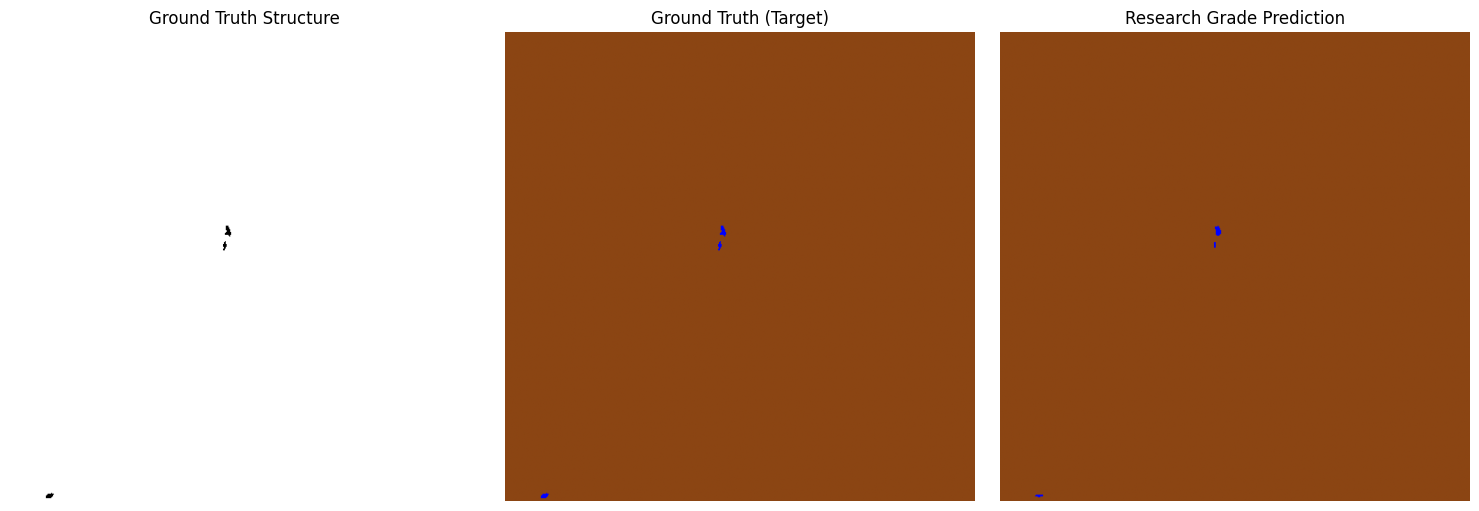

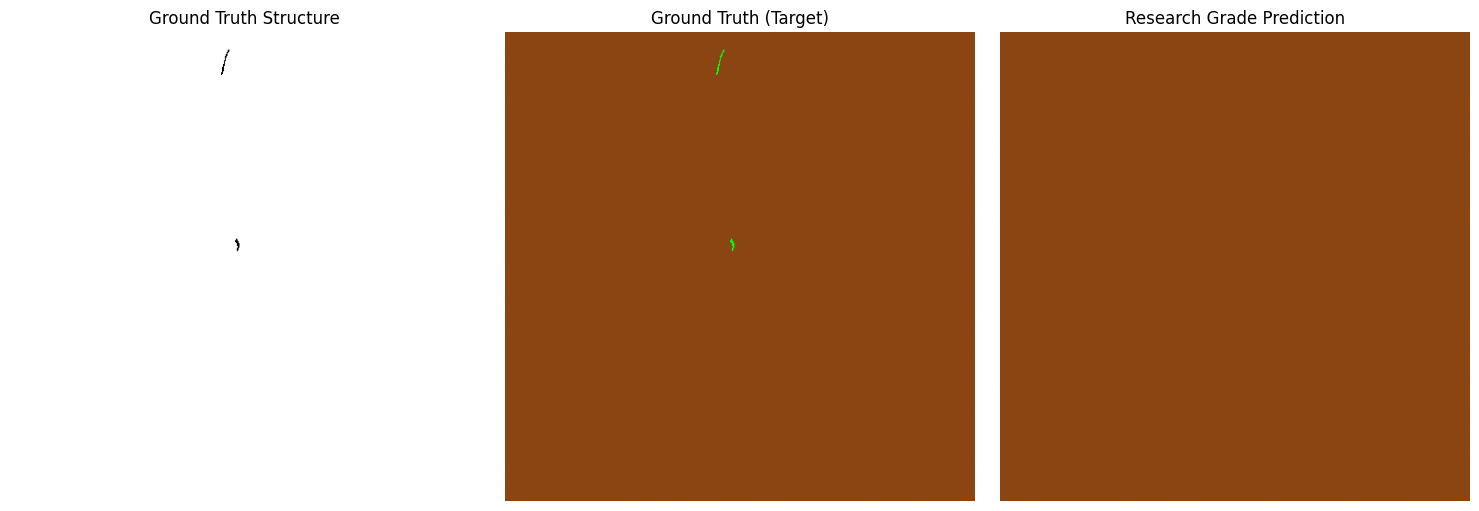

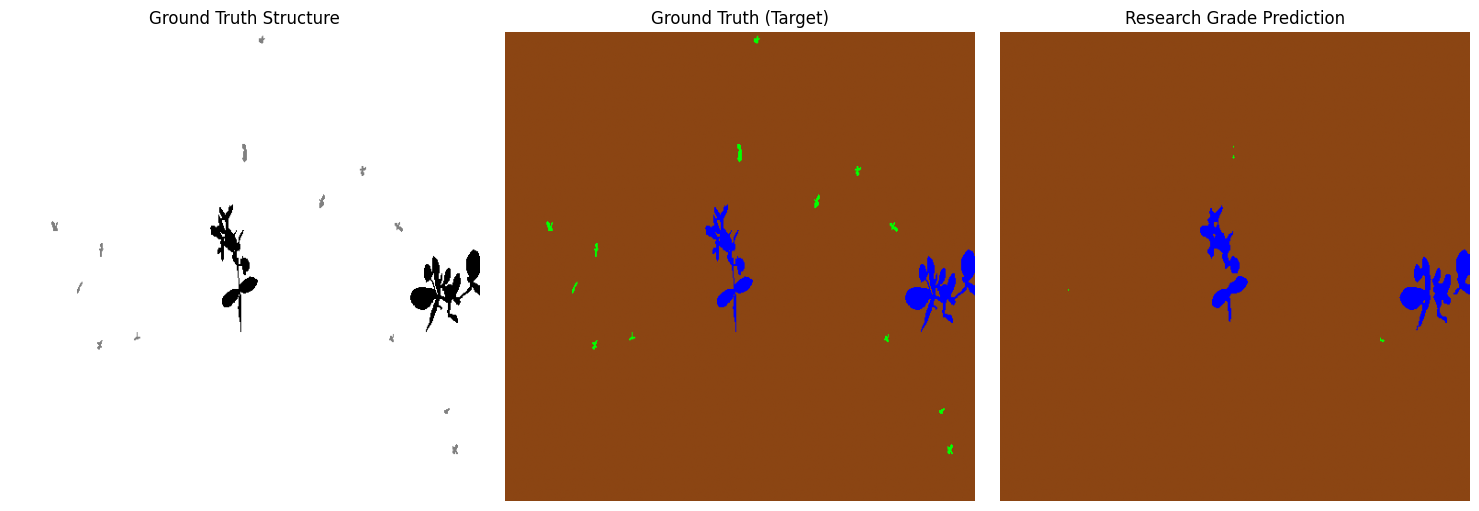

In [ ]:
import os
import torch

# --- 1. Define the Exact Path ---
# We point directly to the folder and file you confirmed exists
folder_name = r"C:\Users\arvap\OneDrive\Documents\Desktop\revitt\segformer_crop_weed_finetuned_v3.2"
filename = "custom_model_best.pth"
weights_path = os.path.join(folder_name, filename)

print(f"Targeting weights at: {weights_path}")

# --- 2. Initialize the Architecture ---
# We build the empty 'Research Grade' skeleton first
model_v2 = SegFormer_Research_Grade(
    pretrained_model_name="nvidia/segformer-b2-finetuned-ade-512-512",
    num_classes=3
)

# --- 3. Load the Weights ---
if os.path.exists(weights_path):
    # Load weights to CPU first to avoid memory errors, then move to GPU
    state_dict = torch.load(weights_path, map_location=device)
    model_v2.load_state_dict(state_dict)

    # Move to GPU
    model_v2.to(device)
    model_v2.eval()
    print("SUCCESS: Model V2 loaded and ready.")

    # --- 4. Run Visualization ---
    # This uses your previously defined visualize_predictions function
    if 'val_dataloader' in locals():
        visualize_predictions(model_v2, val_dataloader, num_samples=3)
    else:
        print("Error: val_dataloader is not defined. Please run the Dataset Setup block first.")

else:
    print(f"ERROR: File not found at {weights_path}")
    print("Double check that the folder name is exactly 'segformer_crop_weed_finetuned_v2'")

Targeting weights at: C:\Users\arvap\OneDrive\Documents\Desktop\revitt\segformer_crop_weed_finetuned_v3.2\custom_model_best.pth


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([3, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SUCCESS: Model V2 loaded and ready.

Visualizing 3 RANDOM validation samples...


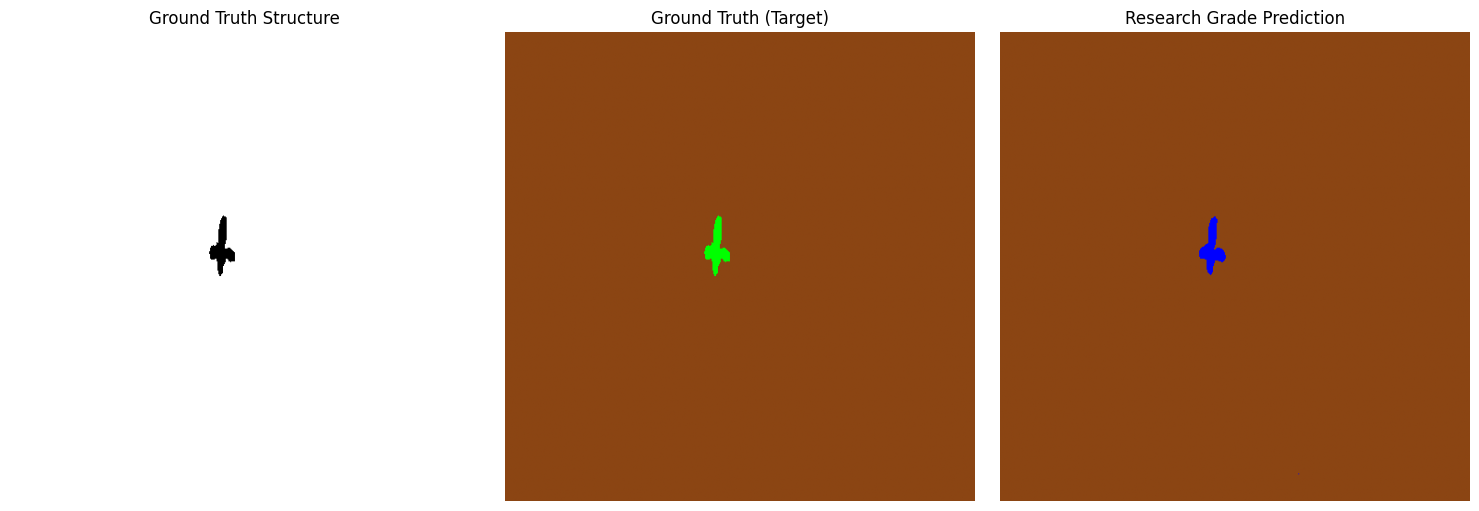

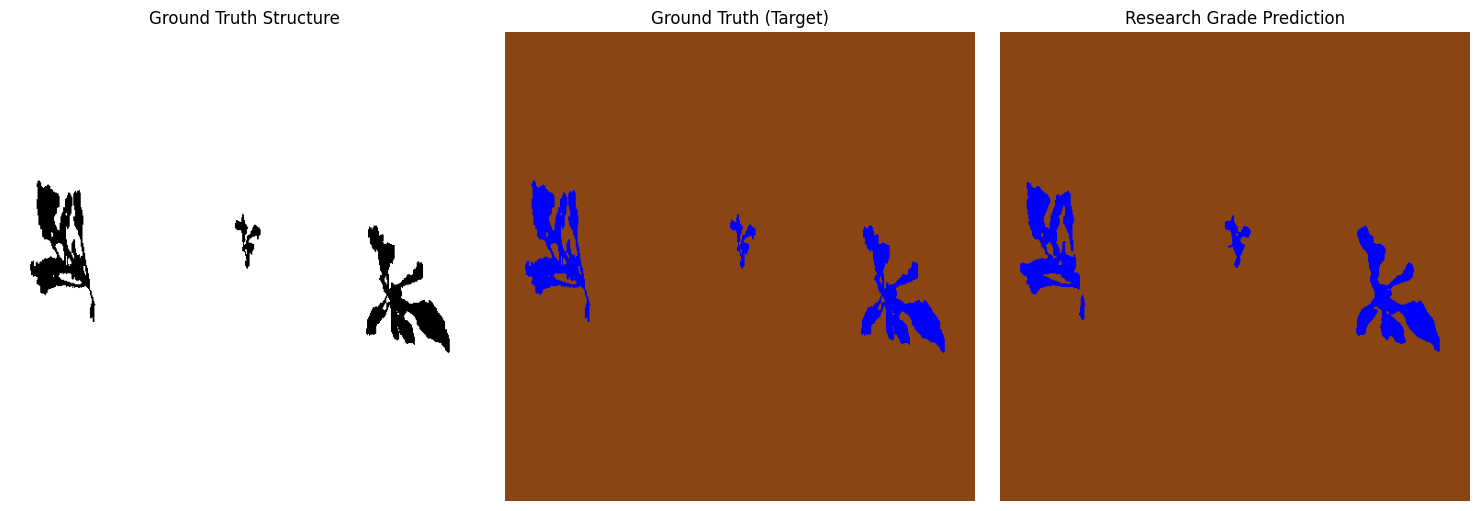

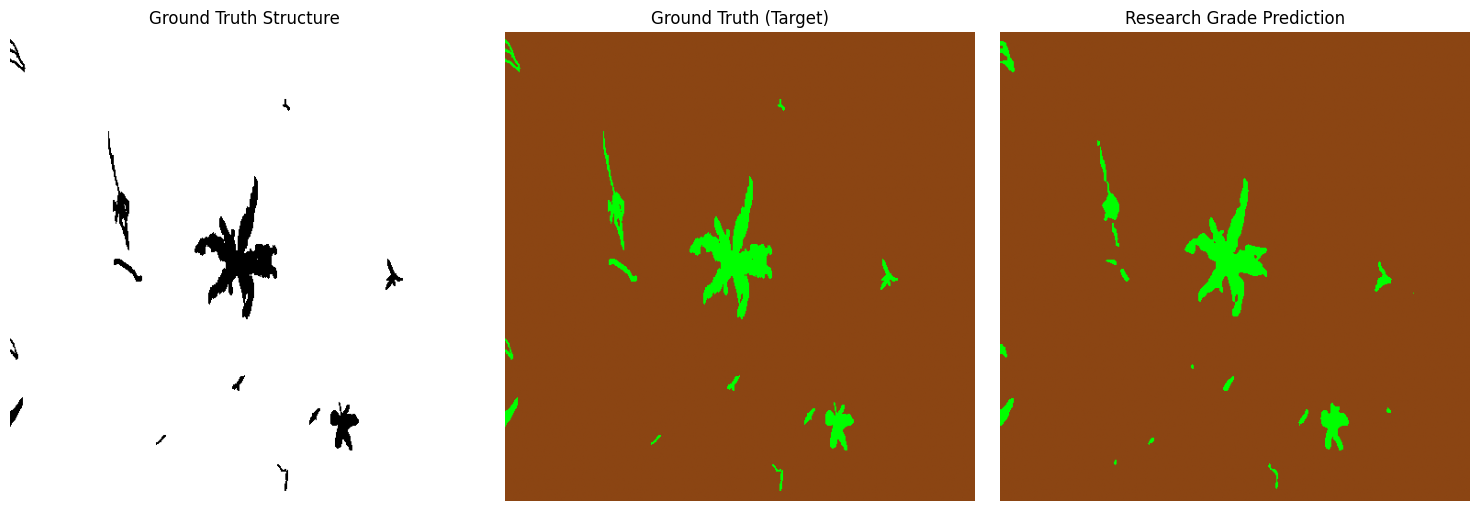

In [ ]:
import os
import torch

# --- 1. Define the Exact Path ---
# We point directly to the folder and file you confirmed exists
folder_name = r"C:\Users\arvap\OneDrive\Documents\Desktop\revitt\segformer_crop_weed_finetuned_v3.2"
filename = "custom_model_best.pth"
weights_path = os.path.join(folder_name, filename)

print(f"Targeting weights at: {weights_path}")

# --- 2. Initialize the Architecture ---
# We build the empty 'Research Grade' skeleton first
model_v2 = SegFormer_Research_Grade(
    pretrained_model_name="nvidia/segformer-b2-finetuned-ade-512-512",
    num_classes=3
)

# --- 3. Load the Weights ---
if os.path.exists(weights_path):
    # Load weights to CPU first to avoid memory errors, then move to GPU
    state_dict = torch.load(weights_path, map_location=device)
    model_v2.load_state_dict(state_dict)

    # Move to GPU
    model_v2.to(device)
    model_v2.eval()
    print("SUCCESS: Model V2 loaded and ready.")

    # --- 4. Run Visualization ---
    # This uses your previously defined visualize_predictions function
    if 'val_dataloader' in locals():
        visualize_predictions(model_v2, val_dataloader, num_samples=3)
    else:
        print("Error: val_dataloader is not defined. Please run the Dataset Setup block first.")

else:
    print(f"ERROR: File not found at {weights_path}")
    print("Double check that the folder name is exactly 'segformer_crop_weed_finetuned_v2'")

Targeting weights at: C:\Users\arvap\OneDrive\Documents\Desktop\revitt\segformer_crop_weed_finetuned_v3.2\custom_model_best.pth


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([3, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SUCCESS: Model V2 loaded and ready.

Visualizing 3 RANDOM validation samples...


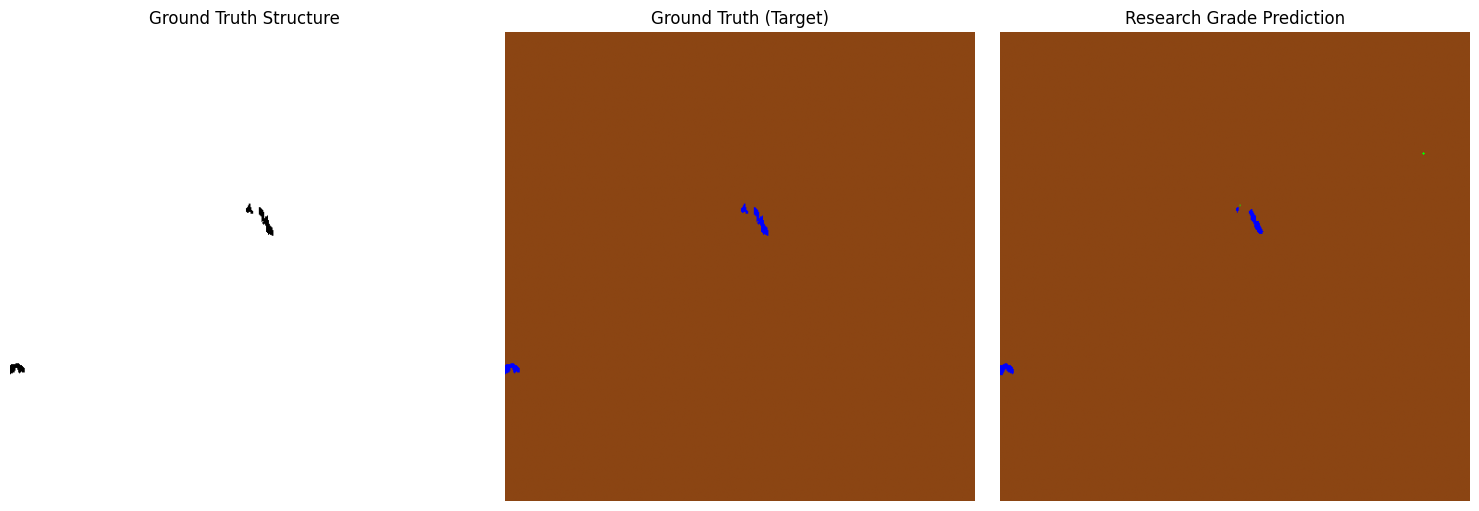

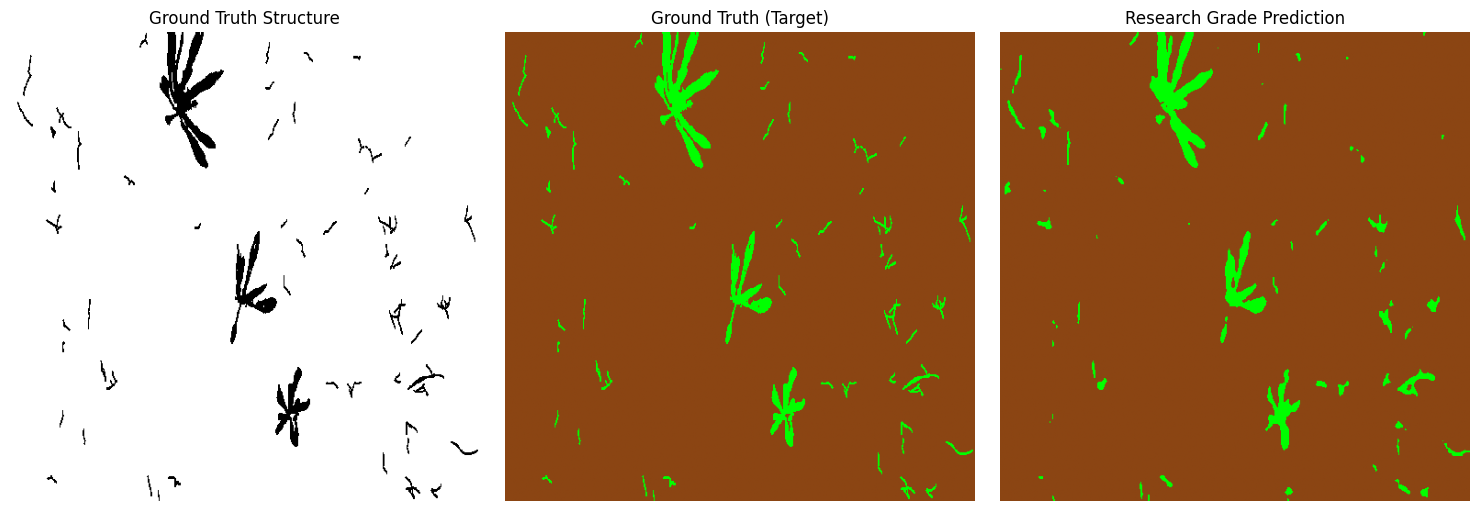

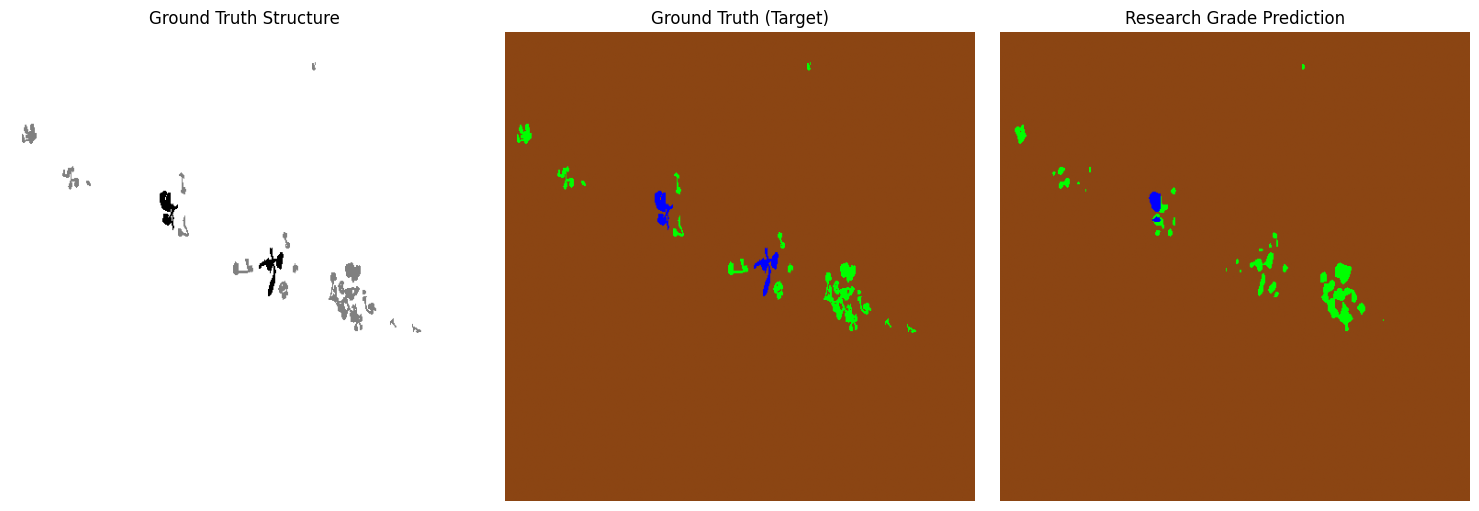

In [ ]:
import os
import torch

# --- 1. Define the Exact Path ---
# We point directly to the folder and file you confirmed exists
folder_name = r"C:\Users\arvap\OneDrive\Documents\Desktop\revitt\segformer_crop_weed_finetuned_v3.2"
filename = "custom_model_best.pth"
weights_path = os.path.join(folder_name, filename)

print(f"Targeting weights at: {weights_path}")

# --- 2. Initialize the Architecture ---
# We build the empty 'Research Grade' skeleton first
model_v2 = SegFormer_Research_Grade(
    pretrained_model_name="nvidia/segformer-b2-finetuned-ade-512-512",
    num_classes=3
)

# --- 3. Load the Weights ---
if os.path.exists(weights_path):
    # Load weights to CPU first to avoid memory errors, then move to GPU
    state_dict = torch.load(weights_path, map_location=device)
    model_v2.load_state_dict(state_dict)

    # Move to GPU
    model_v2.to(device)
    model_v2.eval()
    print("SUCCESS: Model V2 loaded and ready.")

    # --- 4. Run Visualization ---
    # This uses your previously defined visualize_predictions function
    if 'val_dataloader' in locals():
        visualize_predictions(model_v2, val_dataloader, num_samples=3)
    else:
        print("Error: val_dataloader is not defined. Please run the Dataset Setup block first.")

else:
    print(f"ERROR: File not found at {weights_path}")
    print("Double check that the folder name is exactly 'segformer_crop_weed_finetuned_v2'")

Targeting weights at: C:\Users\arvap\OneDrive\Documents\Desktop\revitt\segformer_crop_weed_finetuned_v3.2\custom_model_best.pth


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([3, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SUCCESS: Model V2 loaded and ready.

Visualizing 3 RANDOM validation samples...


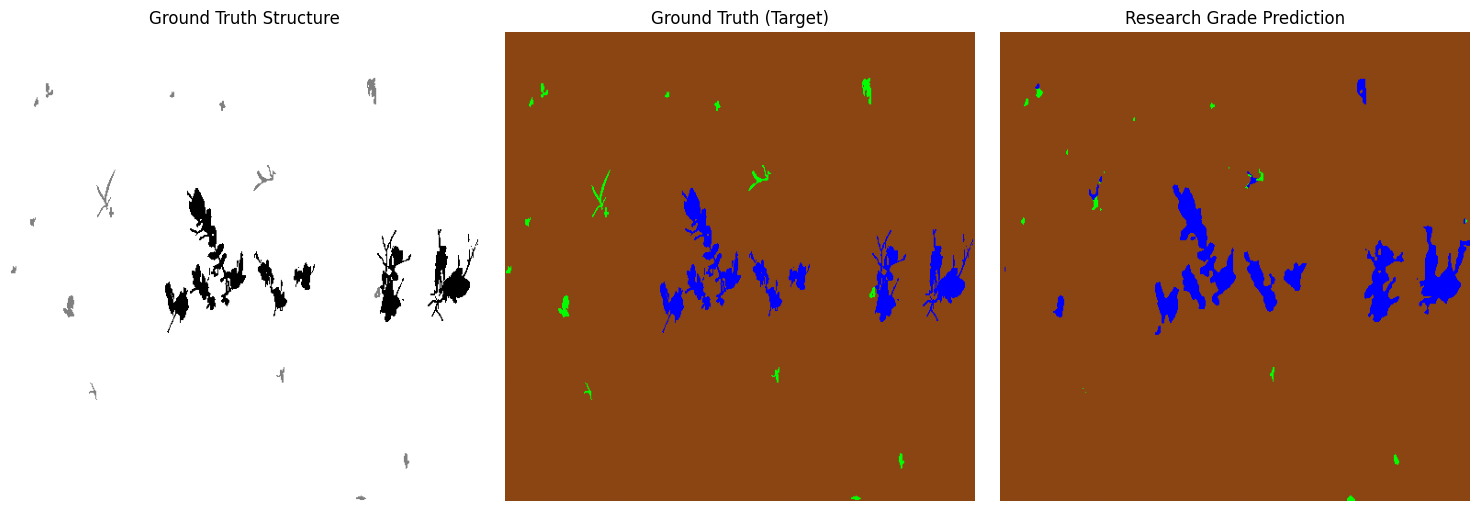

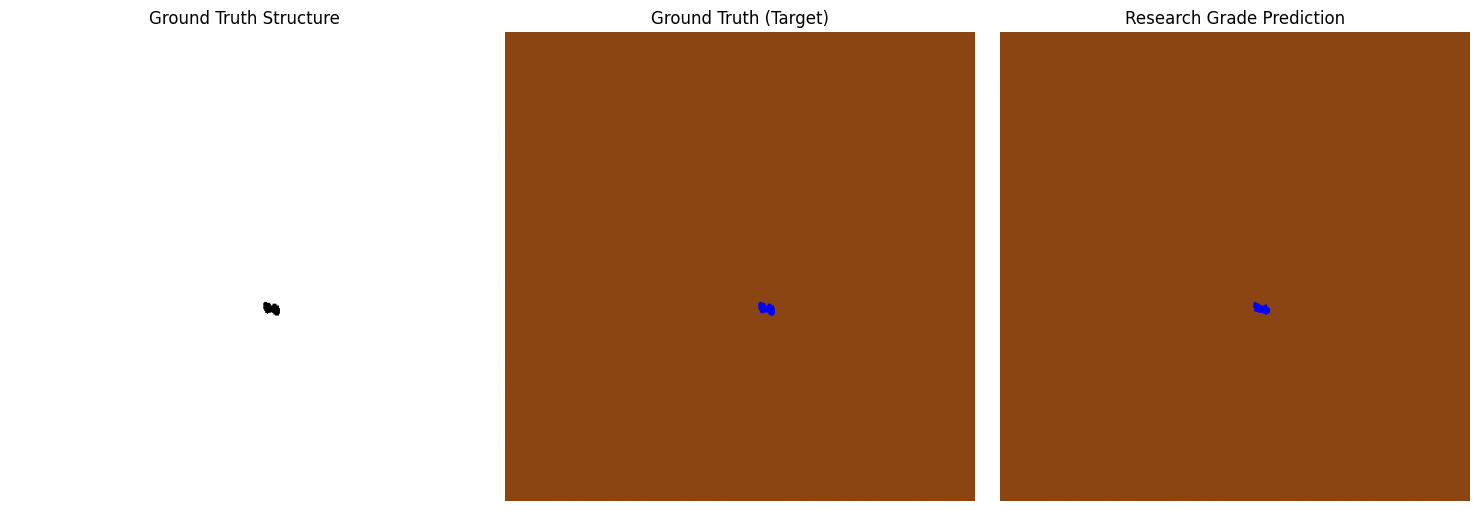

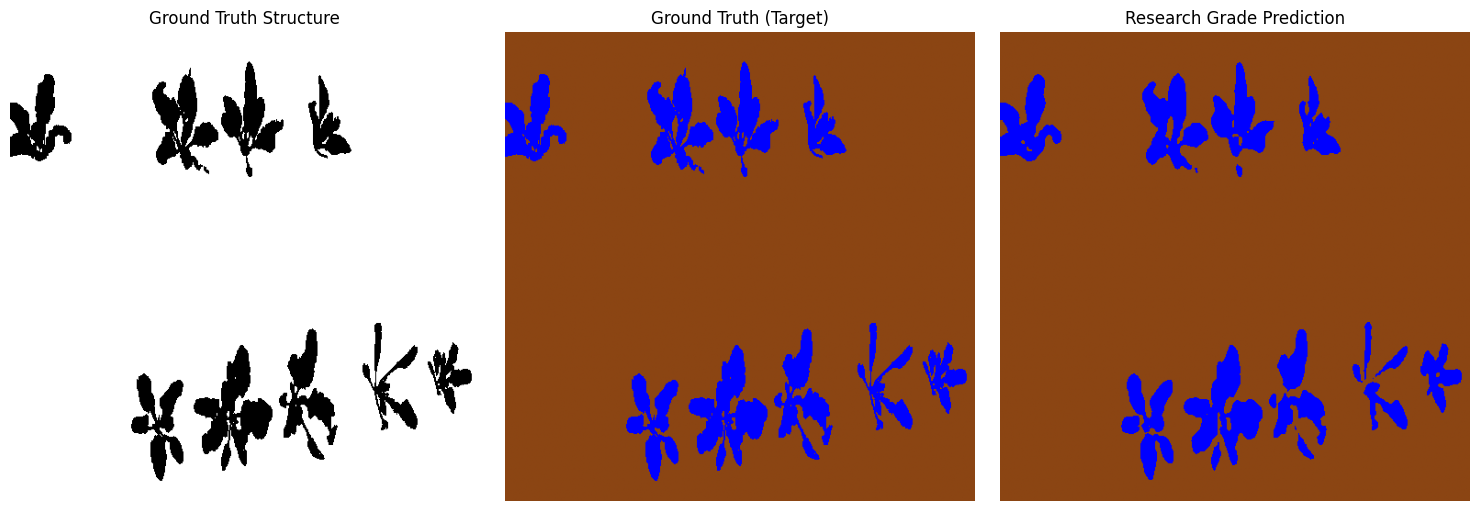

In [ ]:
import os
import torch

# --- 1. Define the Exact Path ---
# We point directly to the folder and file you confirmed exists
folder_name = r"C:\Users\arvap\OneDrive\Documents\Desktop\revitt\segformer_crop_weed_finetuned_v3.2"
filename = "custom_model_best.pth"
weights_path = os.path.join(folder_name, filename)

print(f"Targeting weights at: {weights_path}")

# --- 2. Initialize the Architecture ---
# We build the empty 'Research Grade' skeleton first
model_v2 = SegFormer_Research_Grade(
    pretrained_model_name="nvidia/segformer-b2-finetuned-ade-512-512",
    num_classes=3
)

# --- 3. Load the Weights ---
if os.path.exists(weights_path):
    # Load weights to CPU first to avoid memory errors, then move to GPU
    state_dict = torch.load(weights_path, map_location=device)
    model_v2.load_state_dict(state_dict)

    # Move to GPU
    model_v2.to(device)
    model_v2.eval()
    print("SUCCESS: Model V2 loaded and ready.")

    # --- 4. Run Visualization ---
    # This uses your previously defined visualize_predictions function
    if 'val_dataloader' in locals():
        visualize_predictions(model_v2, val_dataloader, num_samples=3)
    else:
        print("Error: val_dataloader is not defined. Please run the Dataset Setup block first.")

else:
    print(f"ERROR: File not found at {weights_path}")
    print("Double check that the folder name is exactly 'segformer_crop_weed_finetuned_v2'")